# Libraries 

In [1]:
import os
import random
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import glob
import Bio

from Bio.PDB.PDBParser import PDBParser
from Bio.PDB import PDBParser, PPBuilder
from Bio.PDB.Chain import Chain
from Bio.PDB.internal_coords import *
from Bio.PDB.PICIO import write_PIC, read_PIC, read_PIC_seq
from Bio.PDB.ic_rebuild import write_PDB, IC_duplicate, structure_rebuild_test
from Bio.PDB.SCADIO import write_SCAD
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.Polypeptide import is_aa
from Bio.PDB import NeighborSearch

import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D

import preprocessing
import graphconstructor

# Setup, utils

In [2]:
# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain_clean'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

In [3]:
# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

# Load, preprocess

In [4]:
from preprocessing import ProteinAnalyzer

# Initialize ProteinAnalyzer
preprocessing = ProteinAnalyzer(pdb_directory=pdb_directory, aa_info_file=aa_info_file)

# Prepare data
try:
    pdb_files = preprocessing.prepare_data()
except Exception as e:
    print(f"Error during data preparation: {e}")


Processing 1646 PDB files...


Processing PDB files: 100%|██████████| 1646/1646 [09:04<00:00,  3.02it/s, Processed=1646]

Prepared data for 1646 PDB files.


In [5]:
from graphconstructor import GraphConstructor

In [6]:
# To activate when I want to preprocess all structures


# # Initialize the graph constructor
# graphconstructor = GraphConstructor()

# # Example usage with preprocessing output
# dataset = []
# for residues in pdb_files:  # Output from preprocessing.prepare_data()
#     try:
#         graph = graphconstructor.build_graph(residues, distance_threshold=10.0)
#         if graph.x is not None and graph.edge_index.size(1) > 0:
#             dataset.append(graph)
#         else:
#             print(f"Skipped empty graph for residues.")
#     except Exception as e:
#         print(f"Error creating graph: {e}")

# # Initialize DataLoader
# from torch_geometric.loader import DataLoader

# loader = DataLoader(dataset, batch_size=32, shuffle=True)

# # Print dataset size
# print(f"Dataset size: {len(dataset)} graphs")


# check the code on one sample

In [6]:
# Initialize the graph constructor
graphconstructor = GraphConstructor()

# Example residue list (output from preprocessing)
example_residues = pdb_files[0]  # Assuming pdb_residues is the output from prepare_data()

# Build graph with a loading bar
graph = graphconstructor.build_graph(example_residues, distance_threshold=10.0)

# Check graph details
print(graph)


Building graph for 812 residues...


Computing edges: 100%|██████████| 812/812 [00:05<00:00, 151.49it/s]

Data(x=[812, 25], edge_index=[2, 15060], edge_attr=[15060, 1], residues=[812])


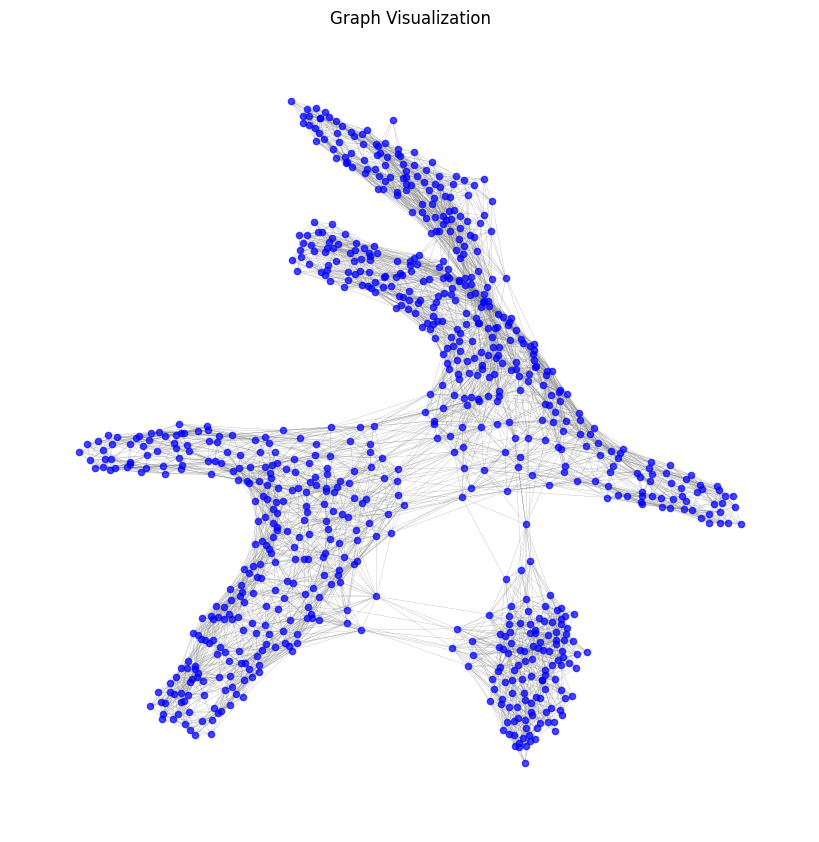

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, node_size=50, edge_width=0.5, figsize=(5, 5)):
    """
    Visualize a PyTorch Geometric graph using NetworkX.

    Args:
        data (Data): PyTorch Geometric Data object.
        node_size (int): Size of the nodes in the plot.
        edge_width (float): Width of the edges in the plot.
        figsize (tuple): Size of the Matplotlib figure.
    """
    # Convert PyTorch Geometric Data to NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Create the plot
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G)  # Spring layout for better node spacing
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=node_size,
        width=edge_width,
        node_color="blue",
        edge_color="gray",
        alpha=0.7,
    )
    plt.title("Graph Visualization")
    plt.show()

# Example usage
visualize_graph(graph, node_size=20, edge_width=0.2, figsize=(8, 8))


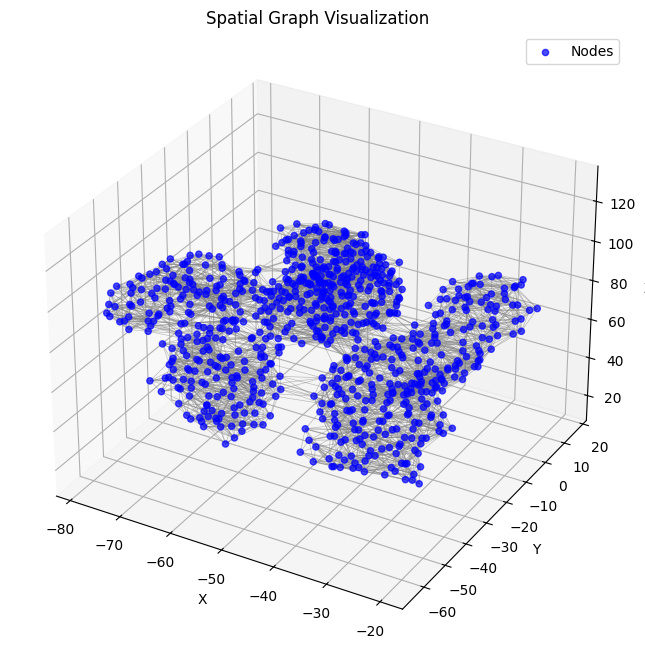

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch_geometric.utils import to_networkx


def visualize_graph_spatial(data, residues, node_size=50, edge_width=0.5, figsize=(10, 10)):
    """
    Visualize a PyTorch Geometric graph in 3D space using residue coordinates.

    Args:
        data (Data): PyTorch Geometric Data object.
        residues (list): List of residue dictionaries, including coordinates.
        node_size (int): Size of the nodes in the plot.
        edge_width (float): Width of the edges in the plot.
        figsize (tuple): Size of the Matplotlib figure.
    """
    # Convert PyTorch Geometric Data to NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Extract spatial positions from residues
    coords = [residue["coord"] for residue in residues]  # List of [x, y, z] positions

    # Create 3D scatter plot for the graph
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Draw nodes using 3D coordinates
    x_nodes, y_nodes, z_nodes = zip(*coords)  # Unpack coordinates
    ax.scatter(x_nodes, y_nodes, z_nodes, s=node_size, c='blue', alpha=0.7, label="Nodes")

    # Draw edges
    for edge in G.edges():
        x_edge = [coords[edge[0]][0], coords[edge[1]][0]]
        y_edge = [coords[edge[0]][1], coords[edge[1]][1]]
        z_edge = [coords[edge[0]][2], coords[edge[1]][2]]
        ax.plot(x_edge, y_edge, z_edge, color="gray", linewidth=edge_width, alpha=0.5)

    # Set plot labels
    ax.set_title("Spatial Graph Visualization")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    plt.legend()
    plt.show()


# Example usage
visualize_graph_spatial(graph, example_residues, node_size=20, edge_width=0.5, figsize=(8, 8))


# use the code on a subset for quicker setup

In [9]:
import random
from torch_geometric.loader import DataLoader

# Set random seed for reproducibility (optional)
random.seed(42)

# Randomly sample 100 proteins from pdb_files
sampled_pdb_files = random.sample(pdb_files, min(100, len(pdb_files)))  # Handles cases with <100 PDBs

# Initialize the graph constructor
graphconstructor = GraphConstructor()

# Build graphs for the sampled proteins
dataset = []
for residues in sampled_pdb_files:  # Use sampled proteins only
    try:
        graph = graphconstructor.build_graph(residues, distance_threshold=10.0)
        if graph.x is not None and graph.edge_index.size(1) > 0:
            dataset.append(graph)
        else:
            print(f"Skipped empty graph for residues.")
    except Exception as e:
        print(f"Error creating graph: {e}")

# Initialize DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Print dataset size
print(f"Dataset size: {len(dataset)} graphs")


Building graph for 1208 residues...


Computing edges: 100%|██████████| 1208/1208 [00:11<00:00, 108.33it/s]


Building graph for 1141 residues...


Computing edges: 100%|██████████| 1141/1141 [00:10<00:00, 113.53it/s]


Building graph for 324 residues...


Computing edges: 100%|██████████| 324/324 [00:00<00:00, 436.49it/s]


Building graph for 996 residues...


Computing edges: 100%|██████████| 996/996 [00:06<00:00, 143.87it/s]


Building graph for 1047 residues...


Computing edges: 100%|██████████| 1047/1047 [00:07<00:00, 139.38it/s]


Building graph for 405 residues...


Computing edges: 100%|██████████| 405/405 [00:01<00:00, 334.53it/s]


Building graph for 639 residues...


Computing edges: 100%|██████████| 639/639 [00:02<00:00, 226.25it/s]


Building graph for 2101 residues...


Computing edges: 100%|██████████| 2101/2101 [00:30<00:00, 68.57it/s]


Building graph for 1139 residues...


Computing edges: 100%|██████████| 1139/1139 [00:09<00:00, 124.60it/s]


Building graph for 825 residues...


Computing edges: 100%|██████████| 825/825 [00:04<00:00, 174.70it/s]


Building graph for 708 residues...


Computing edges: 100%|██████████| 708/708 [00:03<00:00, 191.56it/s]


Building graph for 236 residues...


Computing edges: 100%|██████████| 236/236 [00:00<00:00, 433.32it/s]


Building graph for 483 residues...


Computing edges: 100%|██████████| 483/483 [00:01<00:00, 303.23it/s]


Building graph for 904 residues...


Computing edges: 100%|██████████| 904/904 [00:05<00:00, 158.07it/s]


Building graph for 338 residues...


Computing edges: 100%|██████████| 338/338 [00:00<00:00, 417.04it/s]


Building graph for 631 residues...


Computing edges: 100%|██████████| 631/631 [00:02<00:00, 228.62it/s]


Building graph for 744 residues...


Computing edges: 100%|██████████| 744/744 [00:03<00:00, 192.39it/s]


Building graph for 1015 residues...


Computing edges: 100%|██████████| 1015/1015 [00:07<00:00, 136.62it/s]


Building graph for 448 residues...


Computing edges: 100%|██████████| 448/448 [00:01<00:00, 316.45it/s]


Building graph for 480 residues...


Computing edges: 100%|██████████| 480/480 [00:01<00:00, 308.35it/s]


Building graph for 251 residues...


Computing edges: 100%|██████████| 251/251 [00:00<00:00, 449.32it/s]


Building graph for 1362 residues...


Computing edges: 100%|██████████| 1362/1362 [00:12<00:00, 106.92it/s]


Building graph for 1110 residues...


Computing edges: 100%|██████████| 1110/1110 [00:08<00:00, 124.05it/s]


Building graph for 1128 residues...


Computing edges: 100%|██████████| 1128/1128 [00:08<00:00, 130.14it/s]


Building graph for 272 residues...


Computing edges: 100%|██████████| 272/272 [00:00<00:00, 466.20it/s]


Building graph for 259 residues...


Computing edges: 100%|██████████| 259/259 [00:00<00:00, 550.35it/s]


Building graph for 315 residues...


Computing edges: 100%|██████████| 315/315 [00:00<00:00, 443.28it/s]


Building graph for 482 residues...


Computing edges: 100%|██████████| 482/482 [00:01<00:00, 291.97it/s]


Building graph for 643 residues...


Computing edges: 100%|██████████| 643/643 [00:02<00:00, 229.43it/s]


Building graph for 1290 residues...


Computing edges: 100%|██████████| 1290/1290 [00:12<00:00, 100.24it/s]


Building graph for 118 residues...


Computing edges: 100%|██████████| 118/118 [00:00<00:00, 916.51it/s]


Building graph for 340 residues...


Computing edges: 100%|██████████| 340/340 [00:00<00:00, 381.09it/s]


Building graph for 580 residues...


Computing edges: 100%|██████████| 580/580 [00:02<00:00, 248.20it/s]


Building graph for 1262 residues...


Computing edges: 100%|██████████| 1262/1262 [00:10<00:00, 115.82it/s]


Building graph for 245 residues...


Computing edges: 100%|██████████| 245/245 [00:00<00:00, 496.93it/s]


Building graph for 1020 residues...


Computing edges: 100%|██████████| 1020/1020 [00:07<00:00, 140.97it/s]


Building graph for 472 residues...


Computing edges: 100%|██████████| 472/472 [00:01<00:00, 264.89it/s]


Building graph for 127 residues...


Computing edges: 100%|██████████| 127/127 [00:00<00:00, 810.24it/s]


Building graph for 639 residues...


Computing edges: 100%|██████████| 639/639 [00:02<00:00, 219.29it/s]


Building graph for 518 residues...


Computing edges: 100%|██████████| 518/518 [00:01<00:00, 278.41it/s]


Building graph for 349 residues...


Computing edges: 100%|██████████| 349/349 [00:00<00:00, 372.34it/s]


Building graph for 1272 residues...


Computing edges: 100%|██████████| 1272/1272 [00:11<00:00, 111.70it/s]


Building graph for 254 residues...


Computing edges: 100%|██████████| 254/254 [00:00<00:00, 558.22it/s]


Building graph for 1946 residues...


Computing edges: 100%|██████████| 1946/1946 [00:26<00:00, 74.06it/s]


Building graph for 1277 residues...


Computing edges: 100%|██████████| 1277/1277 [00:11<00:00, 113.52it/s]


Building graph for 595 residues...


Computing edges: 100%|██████████| 595/595 [00:02<00:00, 240.45it/s]


Building graph for 250 residues...


Computing edges: 100%|██████████| 250/250 [00:00<00:00, 468.67it/s]


Building graph for 1009 residues...


Computing edges: 100%|██████████| 1009/1009 [00:07<00:00, 137.74it/s]


Building graph for 238 residues...


Computing edges: 100%|██████████| 238/238 [00:00<00:00, 519.44it/s]


Building graph for 194 residues...


Computing edges: 100%|██████████| 194/194 [00:00<00:00, 683.91it/s]


Building graph for 392 residues...


Computing edges: 100%|██████████| 392/392 [00:01<00:00, 342.52it/s]


Building graph for 1228 residues...


Computing edges: 100%|██████████| 1228/1228 [00:10<00:00, 117.76it/s]


Building graph for 1001 residues...


Computing edges: 100%|██████████| 1001/1001 [00:07<00:00, 139.23it/s]


Building graph for 1130 residues...


Computing edges: 100%|██████████| 1130/1130 [00:08<00:00, 126.48it/s]


Building graph for 1068 residues...


Computing edges: 100%|██████████| 1068/1068 [00:07<00:00, 137.68it/s]


Building graph for 1784 residues...


Computing edges: 100%|██████████| 1784/1784 [00:22<00:00, 80.10it/s]


Building graph for 3289 residues...


Computing edges: 100%|██████████| 3289/3289 [01:14<00:00, 44.00it/s]


Building graph for 383 residues...


Computing edges: 100%|██████████| 383/383 [00:01<00:00, 381.16it/s]


Building graph for 1130 residues...


Computing edges: 100%|██████████| 1130/1130 [00:08<00:00, 127.35it/s]


Building graph for 1154 residues...


Computing edges: 100%|██████████| 1154/1154 [00:09<00:00, 126.74it/s]


Building graph for 3414 residues...


Computing edges: 100%|██████████| 3414/3414 [01:20<00:00, 42.33it/s]


Building graph for 1045 residues...


Computing edges: 100%|██████████| 1045/1045 [00:07<00:00, 139.15it/s]


Building graph for 448 residues...


Computing edges: 100%|██████████| 448/448 [00:01<00:00, 300.07it/s]


Building graph for 852 residues...


Computing edges: 100%|██████████| 852/852 [00:05<00:00, 165.50it/s]


Building graph for 472 residues...


Computing edges: 100%|██████████| 472/472 [00:01<00:00, 298.83it/s]


Building graph for 1794 residues...


Computing edges: 100%|██████████| 1794/1794 [00:22<00:00, 81.08it/s]


Building graph for 1017 residues...


Computing edges: 100%|██████████| 1017/1017 [00:07<00:00, 142.15it/s]


Building graph for 1273 residues...


Computing edges: 100%|██████████| 1273/1273 [00:11<00:00, 110.22it/s]


Building graph for 292 residues...


Computing edges: 100%|██████████| 292/292 [00:00<00:00, 413.37it/s]


Building graph for 1030 residues...


Computing edges: 100%|██████████| 1030/1030 [00:07<00:00, 138.19it/s]


Building graph for 1126 residues...


Computing edges: 100%|██████████| 1126/1126 [00:08<00:00, 125.23it/s]


Building graph for 1022 residues...


Computing edges: 100%|██████████| 1022/1022 [00:07<00:00, 135.92it/s]


Building graph for 402 residues...


Computing edges: 100%|██████████| 402/402 [00:01<00:00, 321.30it/s]


Building graph for 474 residues...


Computing edges: 100%|██████████| 474/474 [00:01<00:00, 301.11it/s]


Building graph for 892 residues...


Computing edges: 100%|██████████| 892/892 [00:05<00:00, 160.09it/s]


Building graph for 2148 residues...


Computing edges: 100%|██████████| 2148/2148 [00:31<00:00, 67.98it/s]


Building graph for 396 residues...


Computing edges: 100%|██████████| 396/396 [00:01<00:00, 356.93it/s]


Building graph for 3678 residues...


Computing edges: 100%|██████████| 3678/3678 [01:31<00:00, 40.01it/s]


Building graph for 560 residues...


Computing edges: 100%|██████████| 560/560 [00:02<00:00, 258.72it/s]


Building graph for 494 residues...


Computing edges: 100%|██████████| 494/494 [00:01<00:00, 266.38it/s]


Building graph for 1992 residues...


Computing edges: 100%|██████████| 1992/1992 [00:27<00:00, 72.73it/s]


Building graph for 575 residues...


Computing edges: 100%|██████████| 575/575 [00:02<00:00, 240.80it/s]


Building graph for 239 residues...


Computing edges: 100%|██████████| 239/239 [00:00<00:00, 571.09it/s]


Building graph for 866 residues...


Computing edges: 100%|██████████| 866/866 [00:05<00:00, 164.31it/s]


Building graph for 312 residues...


Computing edges: 100%|██████████| 312/312 [00:00<00:00, 422.89it/s]


Building graph for 116 residues...


Computing edges: 100%|██████████| 116/116 [00:00<00:00, 1083.06it/s]


Building graph for 1178 residues...


Computing edges: 100%|██████████| 1178/1178 [00:09<00:00, 123.04it/s]


Building graph for 566 residues...


Computing edges: 100%|██████████| 566/566 [00:02<00:00, 246.35it/s]


Building graph for 1794 residues...


Computing edges: 100%|██████████| 1794/1794 [00:22<00:00, 78.62it/s]


Building graph for 1143 residues...


Computing edges: 100%|██████████| 1143/1143 [00:09<00:00, 125.43it/s]


Building graph for 502 residues...


Computing edges: 100%|██████████| 502/502 [00:01<00:00, 261.18it/s]


Building graph for 1043 residues...


Computing edges: 100%|██████████| 1043/1043 [00:07<00:00, 135.51it/s]


Building graph for 6112 residues...


Computing edges: 100%|██████████| 6112/6112 [04:13<00:00, 24.09it/s]


Building graph for 4680 residues...


Computing edges: 100%|██████████| 4680/4680 [02:30<00:00, 31.00it/s]


Building graph for 1287 residues...


Computing edges: 100%|██████████| 1287/1287 [00:11<00:00, 111.39it/s]


Building graph for 1068 residues...


Computing edges: 100%|██████████| 1068/1068 [00:07<00:00, 136.64it/s]


Building graph for 244 residues...


Computing edges: 100%|██████████| 244/244 [00:00<00:00, 500.36it/s]


Building graph for 472 residues...


Computing edges: 100%|██████████| 472/472 [00:01<00:00, 298.77it/s]


Building graph for 113 residues...


Computing edges: 100%|██████████| 113/113 [00:00<00:00, 910.06it/s]


Building graph for 128 residues...


Computing edges: 100%|██████████| 128/128 [00:00<00:00, 749.88it/s]

Dataset size: 100 graphs


In [10]:
print(f"Number of sampled PDBs: {len(sampled_pdb_files)}")
print(f"Dataset size: {len(dataset)} graphs")

Number of sampled PDBs: 100
Dataset size: 100 graphs


In [ ]:
batch = next(iter(loader))  # Get a batch
print(batch.residues)  # Should print the list of residues

# GNN

## Load and check the model

In [12]:
# def vae_loss(mu, logvar, reconstructed_nodes, reconstructed_edges, original_nodes, original_edges):
#     """
#     Compute the VAE loss.

#     Args:
#         mu (torch.Tensor): Mean of latent variables.
#         logvar (torch.Tensor): Log variance of latent variables.
#         reconstructed_nodes (torch.Tensor): Reconstructed node features.
#         reconstructed_edges (torch.Tensor): Reconstructed edge scores.
#         original_nodes (torch.Tensor): Original node features.
#         original_edges (torch.Tensor): Original edge scores.

#     Returns:
#         torch.Tensor: Total VAE loss (KL divergence + reconstruction loss).
#     """
#     # KL Divergence Loss
#     kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

#     # Reconstruction Loss (mean squared error for simplicity)
#     recon_loss_nodes = torch.nn.functional.mse_loss(reconstructed_nodes, original_nodes)
#     recon_loss_edges = torch.nn.functional.mse_loss(reconstructed_edges, original_edges)

#     return kl_loss + recon_loss_nodes + recon_loss_edges


In [12]:
def vae_loss(mu, logvar, reconstructed_nodes, reconstructed_edges, reconstructed_coords, batch):
    """
    Compute the VAE loss.

    Args:
        mu (torch.Tensor): Mean of latent variables.
        logvar (torch.Tensor): Log variance of latent variables.
        reconstructed_nodes (torch.Tensor): Reconstructed node features.
        reconstructed_edges (torch.Tensor): Reconstructed edge weights.
        reconstructed_coords (torch.Tensor): Reconstructed 3D coordinates.
        batch (torch_geometric.data.Batch): Original batch containing node features, edges, and coordinates.

    Returns:
        torch.Tensor: Total loss (KL divergence + reconstruction loss).
    """
    # KL Divergence Loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Node Reconstruction Loss
    node_loss = torch.nn.functional.mse_loss(reconstructed_nodes, batch.x)

    # Edge Reconstruction Loss
    original_edge_weights = torch.ones(batch.edge_index.shape[1]).to(batch.edge_index.device)
    edge_loss = torch.nn.functional.mse_loss(reconstructed_edges, original_edge_weights)

    # Coordinate Reconstruction Loss
    original_coords = torch.tensor([residue["coord"] for residue in batch.residues]).to(batch.x.device)
    coord_loss = torch.nn.functional.mse_loss(reconstructed_coords, original_coords)

    return kl_loss + node_loss + edge_loss + coord_loss



In [13]:
# from vae_graph import GraphVAE
# import torch

In [ ]:
# Temp here to test / play on the changes --> will be in a separate py file, see cell above

import torch
from torch_geometric.nn import GATConv, global_mean_pool, GCNConv

class GraphVAE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim, num_heads=4):
        """
        Graph Variational Autoencoder for mAb generation.

        Args:
            in_channels (int): Input feature size (node features).
            hidden_channels (int): Number of hidden units in GNN layers.
            latent_dim (int): Dimensionality of the latent space.
            num_heads (int): Number of attention heads in GATConv.
        """
        super(GraphVAE, self).__init__()
        # Encoder
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.conv_mu = GATConv(hidden_channels * num_heads, latent_dim, heads=1, concat=False)
        self.conv_logvar = GATConv(hidden_channels * num_heads, latent_dim, heads=1, concat=False)
        self.coord_reconstruct = torch.nn.Linear(hidden_channels, 3)

        # Decoder
        self.decoder_fc = torch.nn.Linear(latent_dim, hidden_channels)
        self.node_reconstruct = torch.nn.Linear(hidden_channels, in_channels)  # Reconstruct node features
        self.edge_reconstruct = torch.nn.Linear(hidden_channels, 1)  # Reconstruct edge weights

    def encode(self, x, edge_index):
        # Encode graph into latent space
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        mu = self.conv_mu(x, edge_index)  # Mean of latent distribution
        logvar = self.conv_logvar(x, edge_index)  # Log variance of latent distribution
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, edge_index):
        """
        Decode latent representation back into graphs.

        Args:
            z (torch.Tensor): Latent space representation (num_nodes x latent_dim).
            edge_index (torch.Tensor): Edge indices of the graph.

        Returns:
            torch.Tensor: Reconstructed node features.
            torch.Tensor: Reconstructed edge scores.
            torch.Tensor: Reconstructed spatial coordinates.
        """
        # Decode node features
        z = torch.relu(self.decoder_fc(z))  # Decode to hidden space
        node_features = self.node_reconstruct(z)  # Reconstruct node features

        # Decode edge features
        src, dest = edge_index[0], edge_index[1]  # Get source and destination nodes for edges
        edge_features = z[src] * z[dest]  # Combine latent features of connected nodes
        edge_scores = self.edge_reconstruct(edge_features).squeeze(-1)  # Reconstruct edge scores

        # Decode spatial coordinates
        coords = self.coord_reconstruct(z)  # New: Reconstruct 3D coordinates

        return node_features, edge_scores, coords

    def forward(self, x, edge_index, batch):    
        print(f"edge_index type: {type(edge_index)}")
        print(f"edge_index value: {edge_index}")

        # Encoder
        mu, logvar = self.encode(x, edge_index)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decoder
        node_features, edge_scores, coords = self.decode(z, edge_index)  # Add coordinate reconstruction

        return mu, logvar, z, node_features, edge_scores, coords

In [23]:
# Hyperparameters --> check what is the net
latent_dim = 32
hidden_channels = 64
in_channels = dataset[0].x.shape[1]

model = GraphVAE(in_channels, hidden_channels, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

GraphVAE(
  (conv1): GATConv(25, 64, heads=4)
  (conv2): GATConv(256, 64, heads=4)
  (conv_mu): GATConv(256, 32, heads=1)
  (conv_logvar): GATConv(256, 32, heads=1)
  (coord_reconstruct): Linear(in_features=64, out_features=3, bias=True)
  (decoder_fc): Linear(in_features=32, out_features=64, bias=True)
  (node_reconstruct): Linear(in_features=64, out_features=25, bias=True)
  (edge_reconstruct): Linear(in_features=64, out_features=1, bias=True)
)


## checks: validate input - output flow

In [24]:
# Sample batch
batch = next(iter(loader))  # Get a batch from DataLoader

In [25]:
print(batch.edge_index)

tensor([[    0,     0,     0,  ..., 25480, 25480, 25480],
        [    1,     2,     3,  ..., 25477, 25478, 25479]])


In [27]:
# Forward pass through the model  --> check input / output, expected dimensions and numbers 

mu, logvar, z, reconstructed_nodes, reconstructed_edges, reconstructed_coords = model(
    batch.x, batch.edge_index, batch.batch
)

print(f"Latent Space (z): {z.shape}")
print(f"Reconstructed Nodes: {reconstructed_nodes.shape}")
print(f"Reconstructed Edges: {reconstructed_edges.shape}")
print(f"Reconstructed Coordinates: {reconstructed_coords.shape}")


edge_index type: <class 'torch.Tensor'>
edge_index value: tensor([[    0,     0,     0,  ..., 25480, 25480, 25480],
        [    1,     2,     3,  ..., 25477, 25478, 25479]])
Latent Space (z): torch.Size([25481, 32])
Reconstructed Nodes: torch.Size([25481, 25])
Reconstructed Edges: torch.Size([645204])
Reconstructed Coordinates: torch.Size([25481, 3])


## Training 

In [19]:
# Working loss function but without the coordinates

# def vae_loss(mu, logvar, reconstructed_nodes, reconstructed_edges, batch):
#     """
#     Compute the VAE loss.

#     Args:
#         mu (torch.Tensor): Mean of latent variables.
#         logvar (torch.Tensor): Log variance of latent variables.
#         reconstructed_nodes (torch.Tensor): Reconstructed node features.
#         reconstructed_edges (torch.Tensor): Reconstructed edge weights.
#         batch (torch_geometric.data.Batch): Original batch containing node features and edges.

#     Returns:
#         torch.Tensor: Total loss (KL divergence + reconstruction loss).
#     """
#     # KL Divergence Loss
#     kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

#     # Node Reconstruction Loss
#     node_loss = torch.nn.functional.mse_loss(reconstructed_nodes, batch.x)

#     # Edge Reconstruction Loss
#     original_edge_weights = torch.ones(batch.edge_index.shape[1]).to(batch.edge_index.device)  # Default weights
#     edge_loss = torch.nn.functional.mse_loss(reconstructed_edges, original_edge_weights)

#     return kl_loss + node_loss + edge_loss


In [22]:
# loss function including coordinates and residues 

def vae_loss(mu, logvar, reconstructed_nodes, reconstructed_edges, reconstructed_coords, batch):
    """
    Compute the VAE loss.

    Args:
        mu (torch.Tensor): Mean of latent variables.
        logvar (torch.Tensor): Log variance of latent variables.
        reconstructed_nodes (torch.Tensor): Reconstructed node features.
        reconstructed_edges (torch.Tensor): Reconstructed edge weights.
        reconstructed_coords (torch.Tensor): Reconstructed 3D coordinates.
        batch (torch_geometric.data.Batch): Original batch containing node features, edges, and coordinates.

    Returns:
        torch.Tensor: Total loss (KL divergence + reconstruction loss).
    """
    # KL Divergence Loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Node Reconstruction Loss
    node_loss = torch.nn.functional.mse_loss(reconstructed_nodes, batch.x)

    # Edge Reconstruction Loss
    original_edge_weights = torch.ones(batch.edge_index.shape[1]).to(batch.edge_index.device)
    edge_loss = torch.nn.functional.mse_loss(reconstructed_edges, original_edge_weights)

    # Coordinate Reconstruction Loss
    original_coords = torch.stack([residue["coord"] for residue in batch.residues]).to(batch.x.device)
    coord_loss = torch.nn.functional.mse_loss(reconstructed_coords, original_coords)

    return kl_loss + node_loss + edge_loss + coord_loss


In [28]:
# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in loader:
        optimizer.zero_grad()

        # Forward pass
        mu, logvar, z, reconstructed_nodes, reconstructed_edges, reconstructed_coords = model(
            batch.x, batch.edge_index, batch.batch
        )

        # Compute loss
        loss = vae_loss(mu, logvar, reconstructed_nodes, reconstructed_edges,reconstructed_coords, batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")



edge_index type: <class 'torch.Tensor'>
edge_index value: tensor([[    0,     0,     0,  ..., 30149, 30149, 30149],
        [    1,     2,     3,  ..., 30146, 30147, 30148]])


AttributeError: 'GlobalStorage' object has no attribute 'residues'

In [23]:
# Save the trained model
torch.save(model.state_dict(), "graphvae_model.pth")

In [ ]:
# Generate a new graph
with torch.no_grad():
    z_sample = torch.randn(1, latent_dim).to(next(model.parameters()).device)  # Sample latent vector
    reconstructed_nodes, reconstructed_edges, reconstructed_coords = model.decode(
        z_sample, torch.tensor([[0], [0]])
    )

    # Create graph with spatial positions
    generated_graph = {
        "nodes": reconstructed_nodes,
        "edges": reconstructed_edges,
        "coords": reconstructed_coords,
    }

    print("Generated Graph:")
    print(generated_graph)


In [24]:
# Without the 3D coordinates

# # Load the trained model (if needed)
# # model.load_state_dict(torch.load("graphvae_model.pth"))
# # model.eval()

# # Generate a new graph
# with torch.no_grad():
#     z_sample = torch.randn(1, latent_dim).to(next(model.parameters()).device)  # Sample latent vector
#     reconstructed_nodes, reconstructed_edges = model.decode(z_sample, torch.tensor([[0], [0]]))

#     print("Generated Node Features:")
#     print(reconstructed_nodes)

#     print("Generated Edge Scores:")
#     print(reconstructed_edges)


Generated Node Features:
tensor([[ 0.0851,  0.0575,  0.0467,  0.0422,  0.0185,  0.0474,  0.0566,  0.0771,
          0.0185,  0.0483,  0.0975,  0.0465,  0.0200,  0.0416,  0.0325,  0.0751,
          0.0617,  0.0209,  0.0399,  0.0670,  0.2302, -0.0026,  0.0200, -0.1172,
          0.0420]])
Generated Edge Scores:
tensor([1.1854])


In [ ]:
# isualize_graph_spatial(graph, reconstructed_nodes, node_size=20, edge_width=0.2)

In [ ]:
# Visualize using the reconstructed coordinates
visualize_graph_spatial(graph, [{"coord": coord.tolist()} for coord in reconstructed_coords])

## Notes, findings: 

- Loss function is the key --> training loop and reconstructions heavily depend on the loss
- test the forward pass before start training, allows to understand if inputv - output are good
- care that all that i need is already in the tensor for the decoder, change one element is a pain
- the graph reconstruction needs all the element to work: residues, coordinates, neighborhood and aminos info (good to have, maybe with the encoded info)